#Topic Modeling with BERT
Leveraging BERT and TF-IDF to create easily interpretable topic

oginal source - https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

<br/>

Often when I am approached by a product owner to do some NLP-based analyses, I am typically asked the following question:
‘Which topic can frequently be found in these documents?’
Void of any categories or labels I am forced to look into unsupervised techniques to extract these topics, namely Topic Modeling.

<br/>

Although topic models such as LDA and NMF have shown to be good starting points, I always felt it took quite some effort through hyperparameter tuning to create meaningful topics.
Moreover, I wanted to use transformer-based models such as BERT as they have shown amazing results in various NLP tasks over the last few years. Pre-trained models are especially helpful as they are supposed to contain more accurate representations of words and sentences.
<br/>
A few weeks ago I saw this great project named Top2Vec* which leveraged document- and word embeddings to create topics that were easily interpretable. I started looking at the code to generalize Top2Vec such that it could be used with pre-trained transformer models.

<br/>

The great advantage of Doc2Vec is that the resulting document- and word embeddings are jointly embedding in the same space which allows document embeddings to be represented by nearby word embeddings. Unfortunately, this proved to be difficult as BERT embeddings are token-based and do not necessarily occupy the same space**.

<br/>
Instead, I decided to come up with a different algorithm that could use BERT and 🤗 transformers embeddings. The result is BERTopic, an algorithm for generating topics using state-of-the-art embeddings.
The main topic of this article will not be the use of BERTopic but a tutorial on how to use BERT to create your own topic model.
PAPER*: Angelov, D. (2020). Top2Vec: Distributed Representations of Topics. arXiv preprint arXiv:2008.09470.
NOTE**: Although you could have them occupy the same space, the resulting size of the word embeddings is quite large due to the contextual nature of BERT. Moreover, there is a chance that the resulting sentence- or document embeddings will degrade in quality.
<br/>

# 1. Data & Packages
For this example, we use the famous 20 Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics. Using Scikit-Learn, we can quickly download and prepare the data:


In [1]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='train')['data']

In [2]:
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



If you want to speed up training, you can select the subset train as it will decrease the number of posts you extract.
NOTE: If you want to apply topic modeling not on the entire document but on the paragraph level, I would suggest splitting your data before creating the embeddings.
<br/>
<br/>
#2. Embeddings
The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word. Not only that, there are many pre-trained models available ready to be used.
How you generate the BERT embeddings for a document is up to you. However, I prefer to use the sentence-transformers package as the resulting embeddings have shown to be of high quality and typically work quite well for document-level embeddings.
Install the package with pip install sentence-transformers before generating the document embeddings. If you run into issues installing this package, then it is worth installing Pytorch first.
Then, run the following code to transform your documents in 512-dimensional vectors:


In [3]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.4 MB 29.4 MB/s 
     |████████████████████████████████| 6.8 MB 48.3 MB/s 
     |████████████████████████████████| 1.2 MB 73.8 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 51.2 MB/s 
     |████████████████████████████████| 895 kB 74.5 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=277c597e8ffe47911b08155e6be6d884aae1348863ce7bef8c931157b1e7f714
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

#Using Distilbert
We are using Distilbert as it gives a nice balance between speed and performance. The package has several multi-lingual models available for you to use.
NOTE: Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting documents into paragraphs.

# 3. Clustering
We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.
UMAP

<br/>

Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.
Install the package with pip install umap-learn before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [5]:
pip install umap-learn

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 28.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=80f3bc818f3b3c8558f08179198e837d6718b9407b2d0772bf88cea0afac256f
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=4755c1f8a1f7d14ace3c5e467ab5998d91d4f361c2122401859d6ec450a6bbb9
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [6]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


#HDBSAN
After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [7]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311904 sha256=f08352b0d20d6932bdbf04e8ffb27a5a499d3267c9154bb327a2de4a6223b674
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [8]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Great! We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

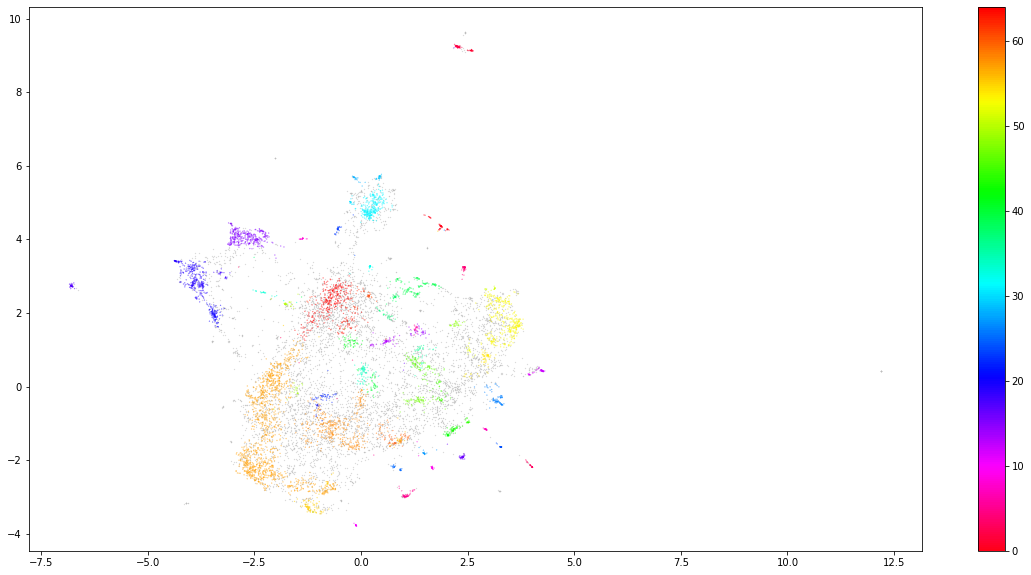

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

It is difficult to visualize the individual clusters due to the number of topics generated (~55). However, we can see that even in 2-dimensional space some local structure is kept.
NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.

<br/>
<br/>

# 4. Topic Creation
What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?
How can we derive topics from clustered documents?
To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.
The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

<br/>

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

## c-TF-IDF
To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:


In [10]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Then, we apply the class-based TF-IDF:

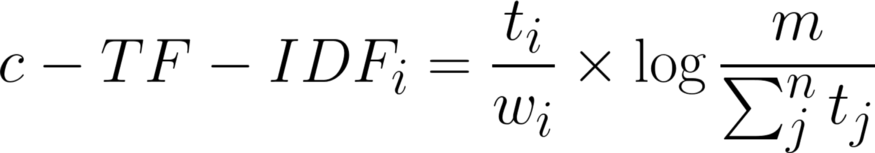

Where the frequency of each word t is extracted for each class i and divided by the total number of words w. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents m is divided by the total frequency of word t across all classes

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.
Topic Representation

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [12]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,5814
58,57,1246
54,53,373
59,58,372
16,15,344
65,64,308
20,19,304
32,31,280
40,39,120
21,20,110


We can use topic_sizes to view how frequent certain topics are:

The topic name-1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.
We can see that topics 7, 43, 12, and 41 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics:


In [13]:
top_n_words[7][:10]

[('br', 0.08093867144054359),
 ('isc', 0.07194447756847819),
 ('thor', 0.057975955885873516),
 ('steveh', 0.055392676223920086),
 ('hendricks', 0.04607499805002426),
 ('government', 0.04033319506434618),
 ('libertarians', 0.034285627504318954),
 ('regulation', 0.02492582587576132),
 ('steve', 0.024596477633022154),
 ('libertarianism', 0.021910269365535296)]

In [14]:
top_n_words[43][:10]

[('encryption', 0.040518280058629896),
 ('clipper', 0.027012956198699405),
 ('key', 0.025282247327881868),
 ('algorithm', 0.02367818432013633),
 ('chip', 0.021738574863272794),
 ('secret', 0.020555228503721792),
 ('keys', 0.019028911480128707),
 ('crypto', 0.01732902015942629),
 ('gtoal', 0.016687231775865386),
 ('scheme', 0.016237506224655425)]

In [15]:
top_n_words[12][:10]

[('gay', 0.055404284376472664),
 ('homosexual', 0.049944771001088),
 ('men', 0.04991000036282396),
 ('male', 0.03437755751306952),
 ('sexual', 0.03400160891416318),
 ('partners', 0.03159497028505754),
 ('study', 0.03157404883926563),
 ('promiscuous', 0.030161664751011116),
 ('cramer', 0.029832429954279493),
 ('optilink', 0.027885459957617452)]

In [16]:
top_n_words[41][:10]

[('austin', 0.029302239800926003),
 ('utexas', 0.028697167052023003),
 ('houston', 0.017247807237366256),
 ('ibm', 0.015597724569185185),
 ('texas', 0.013407434800871235),
 ('cc', 0.012111069220740858),
 ('ccwf', 0.011666143357695044),
 ('mcguire', 0.009680811452662379),
 ('karner', 0.009659417436170978),
 ('turpin', 0.009366582046900288)]

Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics!
I can see sports, computers, space, and religion as clear topics that were extracted from the data.

#5. Topic Reduction
There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to specify the exact number of clusters.

<br/>
A nifty trick that Top2Vec was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.
We can use a similar technique by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [21]:
!pip install cosine_similarity

In [34]:
import sklearn


for i in range(20):
    # Calculate cosine similarity
    similarities = sklearn.metrics.pairwise.cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Topic,Size
0,-1,5814
40,39,1333
41,40,403
36,35,390
11,10,363
14,13,350
21,20,316
45,44,308
26,25,135
32,31,116


Above, we took the least common topic and merged it with the most similar topic. By repeating this 19 more times we reduced the number of topics from 56 to 36!

###NOTE:
 We can skip the re-calculation part of this pipeline to speed up the topic reduction step. However, it is more accurate to re-calculate the c-TF-IDF vectors as that would better represent the newly generated content of the topics. You can play around with this by, for example, update every n steps to both speed-up the process and still have good topic representations.

###TIP: 
You can use the method described in this article (or simply use BERTopic) to also create sentence-level embeddings. The main advantage of this is the possibility to view the distribution of topics within a single document.
